In [254]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import seaborn as sns
from itertools import combinations
from matplotlib.patches import Ellipse

In [255]:
class GMM:
    def __init__(self, n_components, max_iter=100, tol=1e-6):
        self.n_components = n_components
        self.max_iter = max_iter
        self.tol = tol
        
    def initialize_parameters(self, X):
        n_samples, n_features = X.shape
        self.weights = np.ones(self.n_components) / self.n_components
        random_indices = np.random.choice(n_samples, self.n_components, replace=False)
        self.means = X[random_indices]
        self.covs = [np.cov(X.T) for _ in range(self.n_components)]
        
    def expectation_step(self, X):
        n_samples = X.shape[0]
        responsibilities = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            gaussian = multivariate_normal(mean=self.means[k], cov=self.covs[k])
            responsibilities[:, k] = self.weights[k] * gaussian.pdf(X)
            
        responsibilities_sum = responsibilities.sum(axis=1, keepdims=True)
        responsibilities = responsibilities / responsibilities_sum
        
        return responsibilities
    
    def maximization_step(self, X, responsibilities):
        n_samples = X.shape[0]
        Nk = responsibilities.sum(axis=0)
        self.weights = Nk / n_samples
        self.means = np.dot(responsibilities.T, X) / Nk[:, np.newaxis]
        
        for k in range(self.n_components):
            diff = X - self.means[k]
            self.covs[k] = np.dot(responsibilities[:, k] * diff.T, diff) / Nk[k]
            self.covs[k] += np.eye(X.shape[1]) * 1e-6
    
    def compute_log_likelihood(self, X):
        n_samples = X.shape[0]
        likelihood = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            gaussian = multivariate_normal(mean=self.means[k], cov=self.covs[k])
            likelihood[:, k] = self.weights[k] * gaussian.pdf(X)
            
        return np.sum(np.log(np.sum(likelihood, axis=1)))
    
    def fit(self, X):
        self.initialize_parameters(X)
        prev_log_likelihood = None
        self.log_likelihood_history = []
        self.konvergen_iter = 0
        
        for iteration in range(self.max_iter):
            responsibilities = self.expectation_step(X)
            self.maximization_step(X, responsibilities)
            log_likelihood = self.compute_log_likelihood(X)
            self.log_likelihood_history.append(log_likelihood)
            
            if prev_log_likelihood is not None:
                change = abs(log_likelihood - prev_log_likelihood)
                if change < self.tol:
                    self.konvergen_iter = iteration+1
                    break
                    
            prev_log_likelihood = log_likelihood
            
        return self
    
    def predict(self, X):
        responsibilities = self.expectation_step(X)
        return np.argmax(responsibilities, axis=1)


In [256]:
# Implementasi perhitungan silhouette score
def calculate_silhouette_score_manual(X, labels):
    n_samples = X.shape[0]
    n_clusters = len(np.unique(labels))

    # Inisialisasi silhouette scores
    silhouette_scores = np.zeros(n_samples)
    silhouette_scores_proses = []

    for i in range(n_samples):
        # Cluster dari sampel i
        cluster_i = labels[i]

        # Hitung jarak rata-rata sampel i ke sampel lain di cluster yang sama (a_i)
        indices_same_cluster = np.where(labels == cluster_i)[0]
        indices_same_cluster = indices_same_cluster[indices_same_cluster != i]

        if len(indices_same_cluster) == 0:  # Jika sampel sendiri di cluster
            a_i = 0
        else:
            # Hitung jarak Euclidean ke semua sampel di cluster yang sama
            distances_same_cluster = np.sqrt(np.sum((X[i] - X[indices_same_cluster]) ** 2, axis=1))
            a_i = np.mean(distances_same_cluster)

        # Inisialisasi b_i (jarak ke cluster terdekat)
        b_i = np.inf

        # Cek setiap cluster lain
        for cluster in range(n_clusters):
            if cluster != cluster_i:
                # Hitung jarak rata-rata ke sampel di cluster lain
                indices_other_cluster = np.where(labels == cluster)[0]
                if len(indices_other_cluster) > 0:
                    distances_other_cluster = np.sqrt(np.sum((X[i] - X[indices_other_cluster]) ** 2, axis=1))
                    mean_distance = np.mean(distances_other_cluster)

                    # Update b_i jika ditemukan cluster yang lebih dekat
                    if mean_distance < b_i:
                        b_i = mean_distance

        # Hitung silhouette score untuk sampel i
        if a_i == 0 and b_i == np.inf:  # Kasus ekstrim (cluster sendiri dan tidak ada cluster lain)
            silhouette_scores[i] = 0
        elif a_i == 0:  # Sampel sendiri di cluster
            silhouette_scores[i] = 1
        elif b_i == np.inf:  # Tidak ada cluster lain
            silhouette_scores[i] = 0
        else:
            silhouette_scores[i] = (b_i - a_i) / max(a_i, b_i)

        silhouette_scores_proses.append(np.mean(silhouette_scores))

    # Kembalikan nilai silhouette score rata-rata dan nilai per sampel
    return np.mean(silhouette_scores), silhouette_scores, silhouette_scores_proses

In [257]:
# Load dataset Iris
iris = load_iris()
X = iris.data
X1 = iris.data[:, [2, 0]]
y = iris.target
feature_names = iris.feature_names

In [258]:
# Membuat DataFrame untuk memudahkan analisis
iris_df = pd.DataFrame(X, columns=feature_names)
iris_df['target'] = y

In [259]:
# Melihat data
print("== 5 baris pertama dataset Iris ==")
print(iris_df.head())
print("\n== Informasi statistik data ==")
print(iris_df.describe())

== 5 baris pertama dataset Iris ==
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0  

== Informasi statistik data ==
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000

In [260]:
# Standardisasi data (penting untuk PCA)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [261]:
# Melakukan PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

In [262]:
# Pilih 2 komponen pertama untuk visualisasi
pca_2d = PCA(n_components=2)
X_pca_2d = pca_2d.fit_transform(X)

In [263]:
# Implementasi GMM dengan EM
n_components = 3  # Jumlah cluster yang diharapkan (setosa, versicolor, virginica)
Xn = X_pca_2d

In [264]:
# Latih model
np.random.seed(42)  # Untuk hasil yang konsisten
gmm = GMM(n_components=n_components, max_iter=100, tol=1e-4)
gmm.fit(Xn)

# Prediksi cluster
predictions = gmm.predict(Xn)

In [265]:
def plot_ellipse(mean, cov, ax, color, nstd=2):
    """Gambar ellipse berdasarkan mean dan covariance matrix"""
    vals, vecs = np.linalg.eigh(cov)
    angle = np.degrees(np.arctan2(vecs[1, 0], vecs[0, 0]))
    
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=mean, width=width, height=height, angle=angle, 
                    edgecolor=color, facecolor='none',fill=False, linestyle='--')
    ax.add_patch(ellip)

In [266]:
# Analisis kontribusi fitur asli terhadap komponen utama
loadings = pca_2d.components_
loading_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)
print("\n== Kontribusi Fitur Asli ke Komponen Utama ==")
print(loading_df)

# Mencari indeks dengan nilai terbesar di kolom 'PC1'
index_max_pc1 = loading_df['PC1'].idxmax()
index_max_pc2 = loading_df['PC2'].idxmax()
print(f"Indeks dengan kontribusi terbesar di PC1: {index_max_pc1}")
print(f"Indeks dengan kontribusi terbesar di PC2: {index_max_pc2}")


== Kontribusi Fitur Asli ke Komponen Utama ==
                        PC1       PC2
sepal length (cm)  0.361387  0.656589
sepal width (cm)  -0.084523  0.730161
petal length (cm)  0.856671 -0.173373
petal width (cm)   0.358289 -0.075481
Indeks dengan kontribusi terbesar di PC1: petal length (cm)
Indeks dengan kontribusi terbesar di PC2: sepal width (cm)


Text(0, 0.5, 'Log Likelihood')

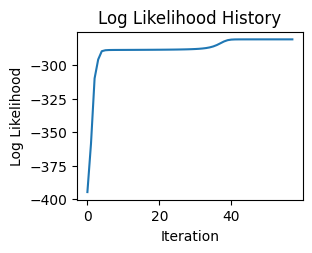

In [267]:
plt.subplot(2, 2, 1)
plt.plot(gmm.log_likelihood_history)
plt.title('Log Likelihood History')
plt.xlabel('Iteration')
plt.ylabel('Log Likelihood')

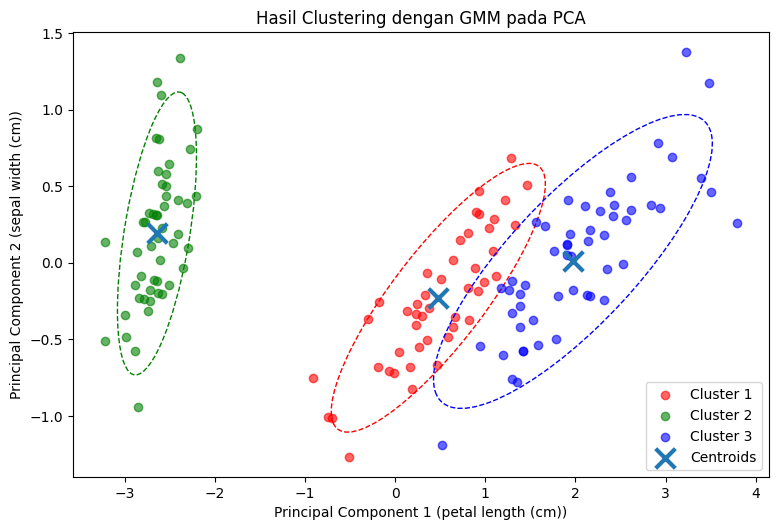

In [268]:
# Buat figure dengan ukuran yang lebih besar
plt.figure(figsize=(15, 10))

colors = ['r', 'g', 'b']

plt.subplot(2, 2, 1)
for k in range(3):
    mask = predictions == k
    plt.scatter(Xn[mask, 0], Xn[mask, 1], c=colors[k], label=f'Cluster {k+1}',
                   alpha=0.6)
    plot_ellipse(gmm.means[k], gmm.covs[k], plt.gca(), colors[k])


plt.scatter(gmm.means[:, 0], gmm.means[:, 1], marker='x',
            s=200, linewidth=3, label=f'Centroids')    
plt.title('Hasil Clustering dengan GMM pada PCA')
plt.xlabel(f'Principal Component 1 ({index_max_pc1})')
plt.ylabel(f'Principal Component 2 ({index_max_pc2})')
plt.legend()

plt.tight_layout()
plt.show()

In [269]:
# Tampilkan hasil numerik
print("\nHasil Clustering GMM-EM pada Dataset Iris:")
print("-" * 50)
print(f"Konvergen pada iterasi {gmm.konvergen_iter}")
# print("Jumlah sampel di setiap cluster:", cluster_sizes)
print("\nMean setiap cluster:")
for i, mean in enumerate(gmm.means):
    print(f"Cluster {i}:", mean)
print("\nProporsi setiap cluster:")
for i, weight in enumerate(gmm.weights):
    print(f"Cluster {i}: {weight:.3f}")
print("\nKovarians setiap cluster:")
for i in range(3):
    print(f"Cluster {i}:")
    print(f"Covariance (Σ):\n{gmm.covs[i]}")


Hasil Clustering GMM-EM pada Dataset Iris:
--------------------------------------------------
Konvergen pada iterasi 58

Mean setiap cluster:
Cluster 0: [ 0.47880353 -0.22916665]
Cluster 1: [-2.64241546  0.19088505]
Cluster 2: [1.97211867 0.00788377]

Proporsi setiap cluster:
Cluster 0: 0.291
Cluster 1: 0.333
Cluster 2: 0.376

Kovarians setiap cluster:
Cluster 0:
Covariance (Σ):
[[0.35257926 0.22036876]
 [0.22036876 0.192499  ]]
Cluster 1:
Covariance (Σ):
[[0.0480425  0.05492185]
 [0.05492185 0.21334436]]
Cluster 2:
Covariance (Σ):
[[0.59788555 0.2973493 ]
 [0.2973493  0.23019455]]


In [270]:
# 5. Hitung silhouette score secara manual
silhouette_avg_manual, silhouette_samples_manual, silhouette_proses = calculate_silhouette_score_manual(X_pca_2d, predictions)

# 6. Tampilkan hasil
print(f"Dataset: Iris (n_samples={Xn.shape[0]}, n_features={Xn.shape[1]})")
print(f"Silhouette Score: {silhouette_avg_manual:.4f}")

# Print detail silhouette score per cluster
for i in range(n_components):
    cluster_silhouette_values = silhouette_samples_manual[predictions == i]
    print(f"Cluster {i} - Jumlah Sampel: {len(cluster_silhouette_values)}")
    print(f"  Min: {np.min(cluster_silhouette_values):.4f}")
    print(f"  Max: {np.max(cluster_silhouette_values):.4f}")
    print(f"  Mean: {np.mean(cluster_silhouette_values):.4f}")
    print(f"  Std: {np.std(cluster_silhouette_values):.4f}")

print("\nSilhouette score per sample ")
for index, sample_item in enumerate(silhouette_proses):
    print(f"Index {index}: {sample_item}")

Dataset: Iris (n_samples=150, n_features=2)
Silhouette Score: 0.5374
Cluster 0 - Jumlah Sampel: 46
  Min: -0.1971
  Max: 0.6564
  Mean: 0.4565
  Std: 0.2109
Cluster 1 - Jumlah Sampel: 50
  Min: 0.6341
  Max: 0.8603
  Mean: 0.8075
  Std: 0.0536
Cluster 2 - Jumlah Sampel: 54
  Min: -0.4389
  Max: 0.5938
  Mean: 0.3562
  Std: 0.2674

Silhouette score per sample 
Index 0: 0.005726062299902169
Index 1: 0.011282918845112289
Index 2: 0.016822535471082225
Index 3: 0.02219723052124915
Index 4: 0.02791098302279047
Index 5: 0.03288434499968464
Index 6: 0.03849988110071672
Index 7: 0.044234897971211364
Index 8: 0.04920157105070205
Index 9: 0.054811182547355335
Index 10: 0.06018483348148314
Index 11: 0.06585957867829376
Index 12: 0.07134987684098038
Index 13: 0.07627147063804597
Index 14: 0.08093887327551412
Index 15: 0.08516649359339566
Index 16: 0.09037756200235668
Index 17: 0.09610591139707836
Index 18: 0.10076916643395063
Index 19: 0.10633891613973302
Index 20: 0.11168422898938464
Index 21: 0.1